# Section 3.2.2 Meta-analysis on consistently differentially expressed genes across diseases

In [1]:
import getpass
import json
import os
import sys
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyobo
import seaborn as sns
from tqdm import tqdm

In [2]:
getpass.getuser()

'rfigueiredo'

In [3]:
sys.version

'3.9.1 (v3.9.1:1e5d33e9b9, Dec  7 2020, 12:10:52) \n[Clang 6.0 (clang-600.0.57)]'

In [4]:
time.asctime()

'Fri Feb 26 19:29:28 2021'

##### Increase figure quality

In [5]:
mpl.rcParams['figure.dpi'] = 320

## Load data
#### download data from https://doi.org/10.5281/zenodo.4572853 and place the folder 'data/' in the root of the repository, or if placed elsewhere, write the full path to 'data/' as the variable data_dir below

#### optional: select your desired location of the output figures

In [6]:
# replace here the location of the data dir if not structured as instructed
data_dir = "../data"

# optional, replace here the desired location of the output figures
figures_dir = os.path.join(os.path.expanduser("~"), "coexpath_figures")
os.makedirs(figures_dir, exist_ok=True)

##### Load cluster assignments

In [7]:
with open(os.path.join(data_dir, "misc_data", 'doid_group_clusters_dict.json'), 'r') as f:
    doids_per_cluster = json.load(f)

doid_cluster_mapping = {doid : cluster for cluster, doid_list in doids_per_cluster.items() if cluster != "Normal" for doid in doid_list}


##### Load disease name mappings

In [8]:
doid_name_mapping = pyobo.get_id_name_mapping('doid')
doid_id_mapping = pyobo.get_name_id_mapping('doid')

##### Load differentially expressed genes

In [9]:
DEgenes_dir = os.path.join(data_dir, "DEgenes")

DEgene_dict = {
    doid : pd.read_table(os.path.join(DEgenes_dir, doid, "DEgenes.tsv"),index_col="HGNC",usecols=["HGNC","adj.P.Val","logFC"])
    for doid in tqdm(os.listdir(DEgenes_dir),desc="loading fold gene data")
}

loading fold gene data: 100%|██████████| 46/46 [00:00<00:00, 64.69it/s]


## Prepare data

##### Create consensus for up- and down-regulated diseases

In [10]:
DE_up_down = {doid: {"up": None, "down": None} for doid in DEgene_dict}
for doid, df in DEgene_dict.items():
    DE_up_down[doid]["up"] = df.loc[df["logFC"]>0]
    DE_up_down[doid]["down"] = df.loc[df["logFC"]<0]

In [11]:
avg_up_df = pd.concat([up_down["up"] for up_down in DE_up_down.values()]).groupby(level=0).mean()
avg_down_df = pd.concat([up_down["down"] for up_down in DE_up_down.values()]).groupby(level=0).mean()
combined_avg_df = pd.concat([avg_up_df,avg_down_df])
combined_avg_df = combined_avg_df.reset_index()


##### analyze cutoffs, label each row with final groupings

In [12]:
def prep_df_for_consensus(df, fc_cutoff):
    """prepare combined df for plotting, adds new column needed for color-labelling
    
    paramaters
    ----------
    df : pd.DataFrame
        combined dataframe with averaged values
    fc_cutoff: float
        absoluted value of chosen fold change cutoff for those most significantly differentially expressed to be highlighted
    """
    df["-log10(adj. p-value)"] = (-1) * np.log10(df["adj.P.Val"].values)
    for row, fc, p in zip(df.index, df["logFC"], df["adj.P.Val"]):
        if p < 0.01:
            if fc < 0:
                if fc < -fc_cutoff:
                    df.at[row, "Legend"] = f"FC<-{fc_cutoff}"
                else:
                    df.at[row, "Legend"] = "Down"
            else:
                if fc > fc_cutoff:
                    df.at[row, "Legend"] = f"FC>{fc_cutoff}"
                else:
                    df.at[row, "Legend"] = "Up"
        else:
            df.at[row, "Legend"] = "adj. p-val > 0.01"
    df = df.drop("adj.P.Val", axis=1)
    df = df.rename(columns={'logFC': 'log2(fold change)'})
    return df

In [13]:
consensus_df = prep_df_for_consensus(combined_avg_df, 1.75)

## Figure: Consensus for consistently differentially expressed genes

In [14]:
sns.set_theme(style="whitegrid")

def volcano(df, fc_cutoff: float, text_location: float):
    """plots consensus for consistently differentially expressed genes
    
    paramaters
    ----------
    df : pd.DataFrame
        dataframe created from prep_df_for_consensus function
    fc_cutoff: float
        absoluted value of chosen fold change cutoff for those most significantly differentially expressed to be highlighted
    text_location: float
        x-axis value of where the text for adj. p-value cutoff line to be shown, depends on df values."""
    f, ax = plt.subplots(figsize=(15, 15))
    plt.rc('axes', labelsize=18)
    p = sns.scatterplot(x="log2(fold change)", y="-log10(adj. p-value)", 
                    hue="Legend", hue_order=[f"FC<-{fc_cutoff}","Down","adj. p-val > 0.01","Up",f"FC>{fc_cutoff}"], palette="coolwarm",
                    linewidth=0,
                    data=df, ax=ax)
    plt.title("Consistently differentially expressed genes in diseases vs normal", fontsize=25, weight="bold")
    p.axhline((-1) * np.log10(.01), color = "red", ls= "--")
    p.text(text_location,(-1) * np.log10(.01), "adj. p-value = 0.01", color="red",
            ha="left", va="center", fontsize = 15)
    plt.legend(fontsize=18,title_fontsize=25)
    
    return p

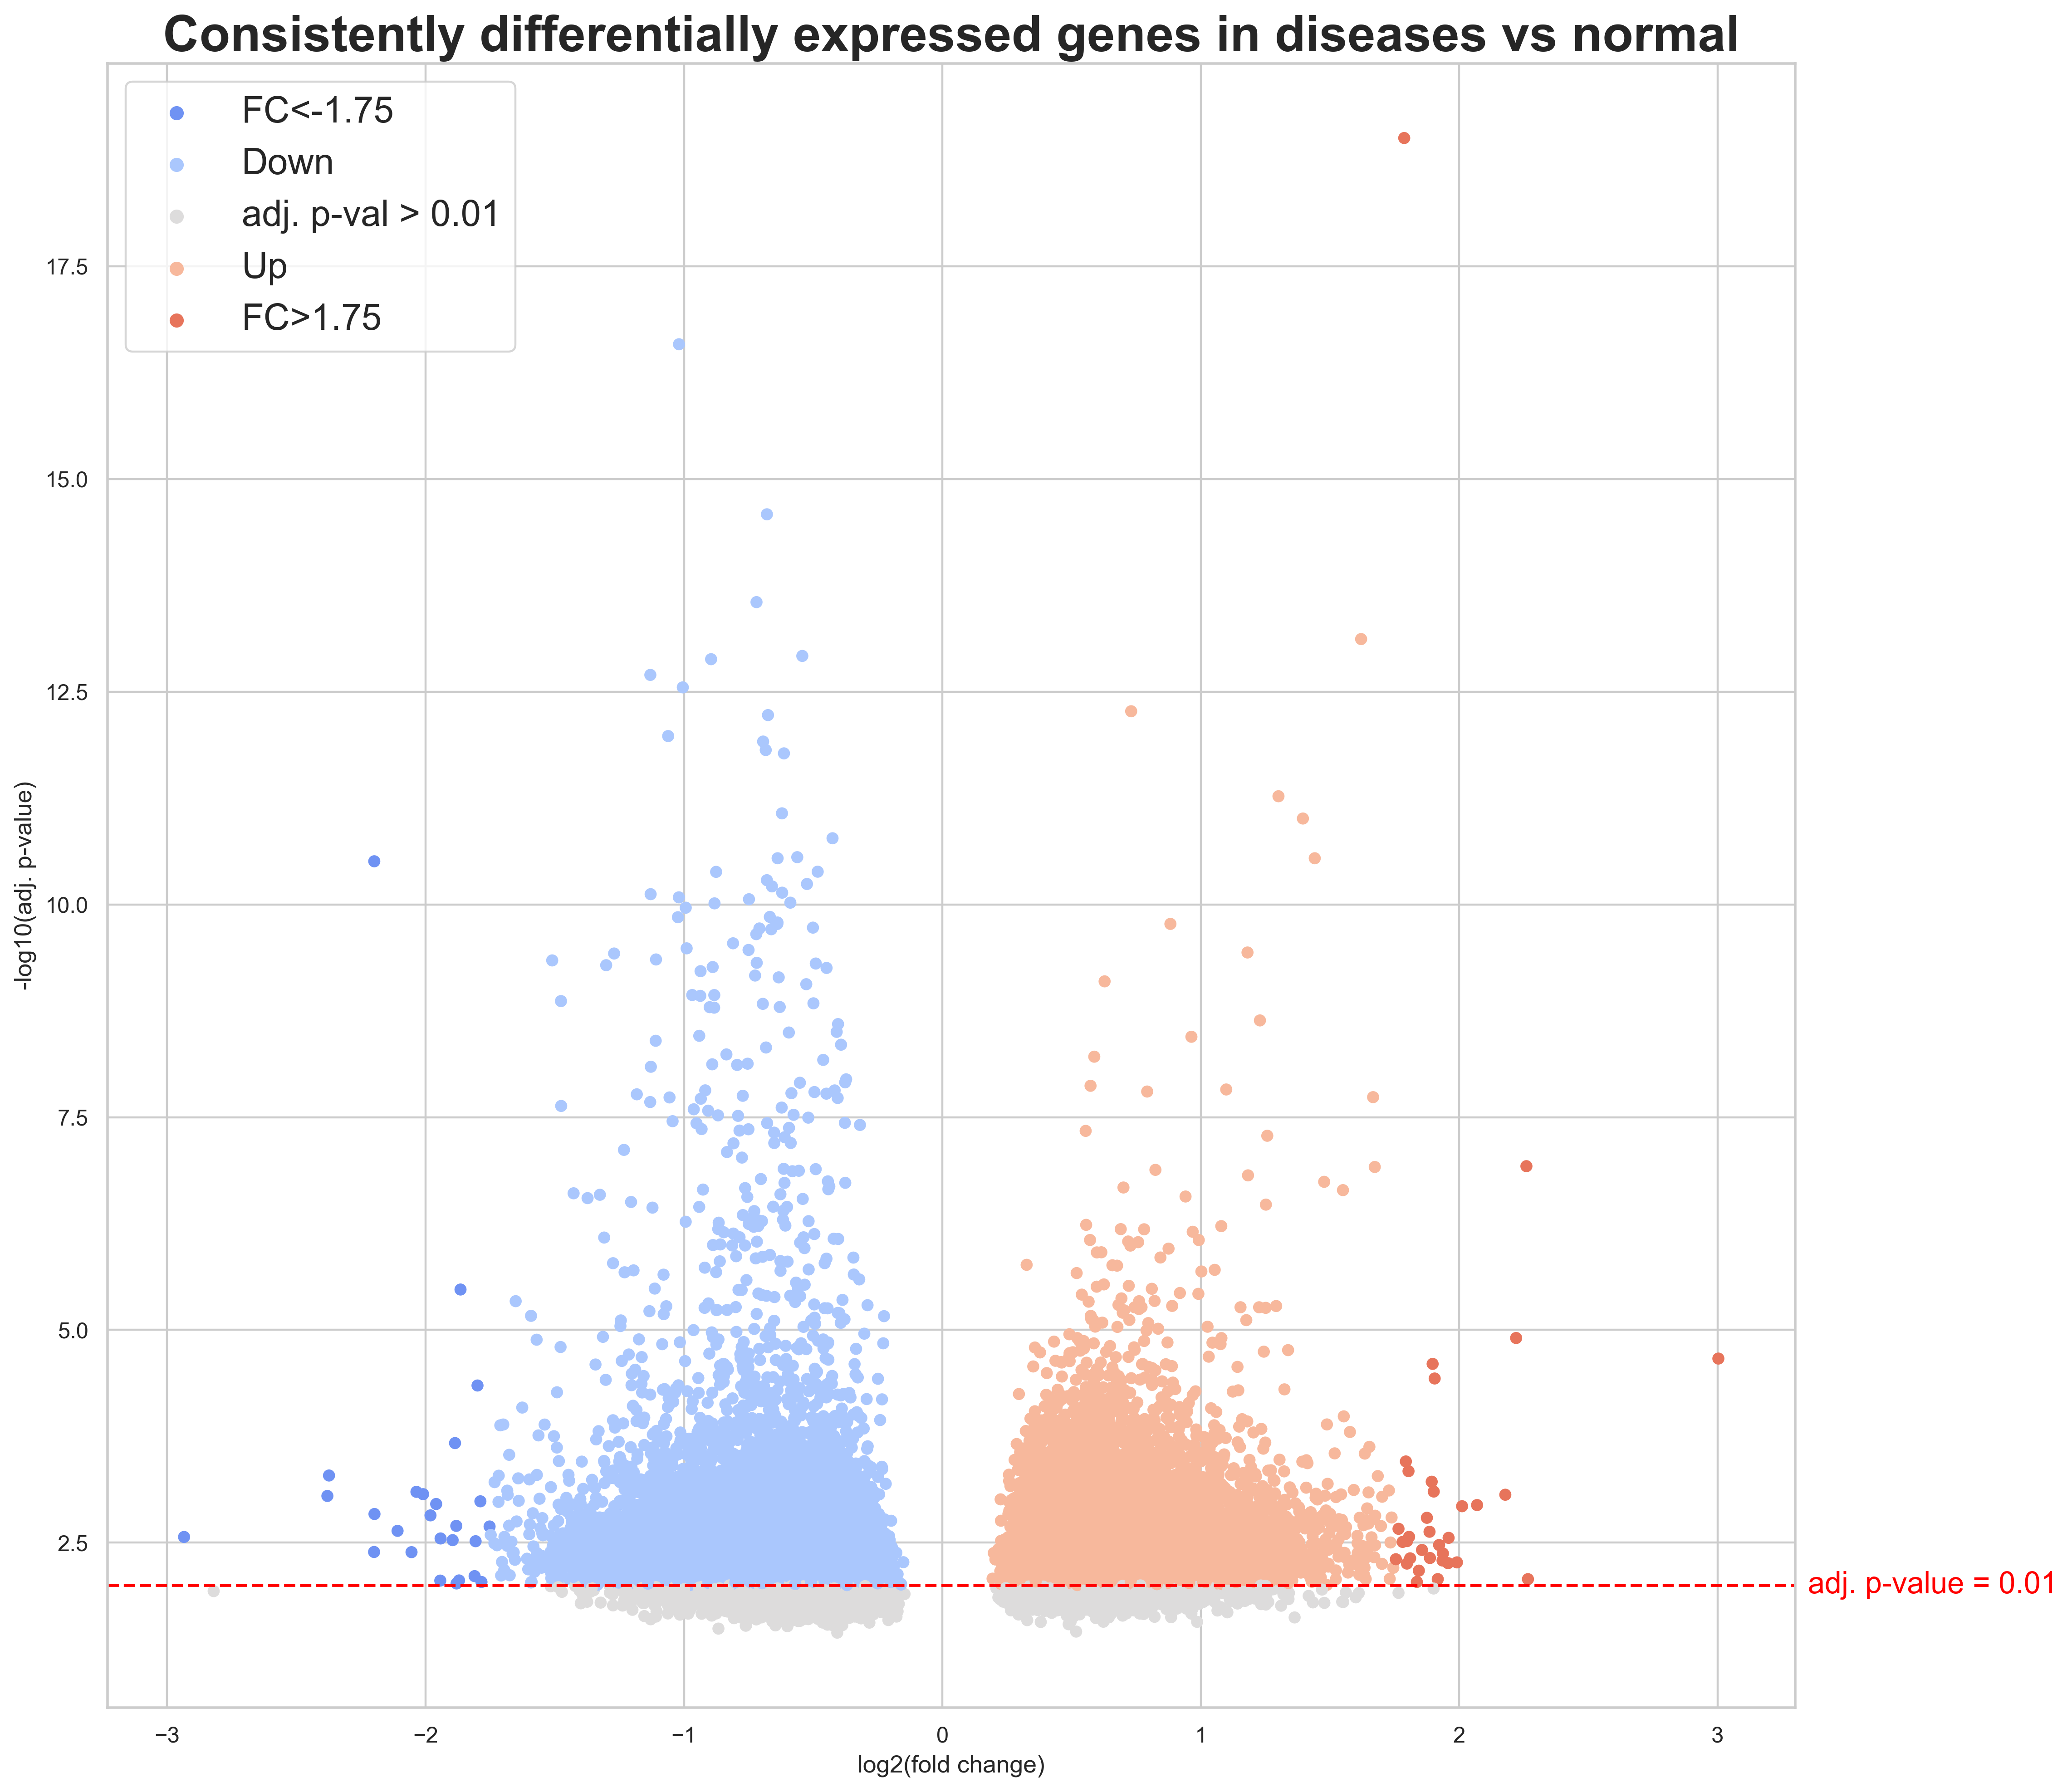

In [15]:
consensus_plot = volcano(consensus_df, 1.75, 3.35)
plt.savefig(os.path.join(figures_dir, "consistently_DEgenes.png"), bbox_inches='tight',dpi=320)